## Continuous Output HMM parameter Estimation

Here we assume discrete states with gaussian output. We simulate such an HMM to generate observation data. Then we apply KL clustering to have an initial estimate of the parameters. Applying EM refines the estimates and then we again simulate our trained and original HMM. We plot the histogram of the two and they match quite well

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt

import pandas as pd
import random
from sklearn.cluster import KMeans

Defining Classes for HMM, and the FB and EM algorithm

In [3]:
class State(object):
    
    def __init__(self, D=1):
        
        self.μ=np.zeros(D)
        self.σ=np.identity(D)
        self.D=D
        
    def P(self, x):
        
        if np.linalg.det(self.σ)<=0:
            return -500
        return -0.5*np.linalg.multi_dot([np.transpose(x-self.μ), np.linalg.inv(self.σ), x-self.μ])
    
    
    def sim(self):
        
        return np.random.multivariate_normal(self.μ, self.σ) 

In [4]:
class HMM(object):
    
    def __init__(self):
        
        self.States=[]
        self.A=np.zeros(1)
        self.p=np.zeros(1)
        self.Current=0
        
    
    def f(self, O):
        
        d=len(O)
        N=len(self.States)
        α=np.zeros([N, d])
        
        
        for i in range(N):
            
            if self.p[i]!=0:
                
                α[i, 0]=log(self.p[i])+self.States[i].P(O[0])
                
            else:
                
                α[i, 0]=-500
        

        for t in range(1, d):
            
            for i in range(N):

                for j in range(N):
                    
                    if α[j, t-1]>-500:

                        α[i, t]+=exp(α[j, t-1]) * self.A[j, i] * exp(self.States[i].P(O[t]))
                        
                  
                if α[i, t]!=0:
                    
                    α[i, t]=log(α[i, t])
                    
                else:
                    
                    α[i, t]=-500
                
                    
        return α
    
    def r(self, O):
        
        d=len(O)
        N=len(self.States)
        β=np.zeros([N, d])
        
        for i in range(N):
            
            β[i, d-1]=0
        
        for nt in range(0, d-1):
            
            t=d-nt-1
            
            for i in range(N):

                for j in range(N):
                    
                    if β[i, t-1]>-500:
                        
                        β[i, t-1]+=exp(β[j, t])*self.A[i, j]*exp(self.States[j].P(O[t]))
                        
        
                    
                if β[i, t-1]!=0:
                    
                    β[i, t-1]=log(β[i, t-1])
                    
                else:
                    
                    β[i, t-1]=-500
                    
        return β
    
    
    def gamma(self, O):
        
        α=self.f(O)
        β=self.r(O)
        d=len(O)
        N=len(self.States)
        γ=np.zeros([N, d])

        
        for t in range(d):
            
            s=0
            
            for i in range(N):
                
                a=α[i, t]+β[i, t]
                γ[i, t]=np.exp(a)
                s+=γ[i, t]
                
                
            if s==0:
                for i in range(N):
                    γ[i, t]=log(1/N)
                
            if s!=0:
                
                for i in range(N):
                    if γ[i, t]==0:
                        γ[i, t]=-500
                    else:
                        γ[i, t]=log(γ[i, t]/s)
                
        return γ
    
    
    def xi(self, O):
        
        α=self.f(O)
        β=self.r(O)
        
        d=len(O)
        N=len(self.States)
        
        ξ=np.zeros([N, N, d-1])
        
        
        for t in range(d-1):
            
           
            s=0
            for i in range(N):
                
                for j in range(N):
        
                    if self.A[i, j] == 0:
                
                        a=-500
                    else:
                        a=α[i, t]+log(self.A[i, j])+self.States[j].P(O[t+1])+(β[j, t+1])
                        ξ[i, j, t]=a
                        s+=np.exp(a)
                    
              
            
            if s==0:
                ξ[:, :, t]=-500
            if s!=0:
                for i in range(N):
                    for j in range(N):
                        ξ[i, j, t]=ξ[i, j, t]-log(s)
            
        return ξ
    
    def sim(self):
        
        TrP=self.A[self.Current]
        Next=np.arange(len(self.States))
        nextIndex=np.random.choice(Next, p=TrP)
        
        self.Current=nextIndex
        
        return self.States[self.Current].sim(), self.Current
    
    def printx(self):
        
        print(self.p)
        print(self.A)
        print()
        
        N=len(self.States)
        
        for i in range(N):
     
            print('State '+str(i+1)+':')
            print(self.States[i].μ)
            print(self.States[i].σ)
            
        print()
        print()
        print()
    
    
    def EM(self, O):
        
        T=len(O)
        D=len(O[0])
        N=len(self.States)
        
        α=np.exp(self.f(O))
        β=np.exp(self.r(O))
        γ=np.exp(self.gamma(O))
        ξ=np.exp(self.xi(O))
        V=self.Viterbi(O)
        
        #To be estimated paras
        μs=np.zeros([N, D])
        σs=np.zeros([N, D, D])
        A=np.zeros([N, N])
        p=np.zeros(N)
        
        #Estimating means
        for i in range(N):
            
            s=0
            for t in range(T):
                
                if V[t]==i:
                    μs[i]+=γ[i, t]*O[t]
                    s+=γ[i, t]
                
            μs[i]=μs[i]/s
            
        #Estimating variances    
        for i in range(N):
            
            s=0
            for t in range(T):
                
                if V[t]==i:
                    e=O[t]-μs[i]
                    σs[i]+=γ[i, t]*np.outer(e, e)
                    s+=γ[i, t]
                
            σs[i]=σs[i]/s
            
        #Estimating transisiton Matrix
        for i in range(N):
            
            s=0
            for j in range(N):
                
                for t in range(T-1):
                    
                    A[i, j]+=ξ[i, j, t]
                    s+=ξ[i, j, t]
                    
                    
            A[i, :]=A[i, :]/s
            
        
        #Estimating p
        p=γ[:, 0]
        
        self.A=A
        #self.p=p
        
        for i in range(N):
            
            self.States[i].μ=μs[i]
            self.States[i].σ=σs[i]
        
    def Pval(self, O):
        
        α=self.f(O)
        
        return sum(np.exp(α[:, -1]))
    
    
    def Viterbi(self, O):
        
        γ=np.exp(self.gamma(O))
        
        V=[]
        N=len(self.States)
        for t in range(len(O)):
            
            o=O[t]
            
            Ps=[]
            pmax=0
            j=0
            for i in range(N):
                p=np.exp(self.States[i].P(o))
                
                if p>pmax:
                    pmax=p
                    j=i
                
            V.append(j)
        return V

Building an HMM and simulating it

In [5]:
A=State(3)
B=State(3)


A.μ=np.array([10, 10, -10])
A.σ=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])


B.μ=np.array([-10, -10, 10])
B.σ=np.array([[3, 0, 0], [0, 3, 0], [0, 0, 3]])


C=HMM()
C.States=[A, B]
C.A=np.array([[0.4, 0.6], [0.5, 0.5]])
C.p=np.array([0.5, 0.5])

In [6]:
O=[]
S=[]
for i in range(1000):
    o, s=C.sim()
    O.append(o)
    S.append(s)
    
O=np.array(O)
Otrain=np.array(O[:100])

    

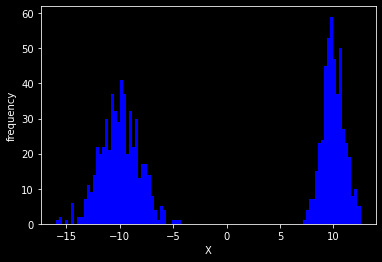

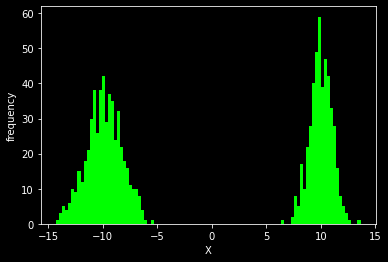

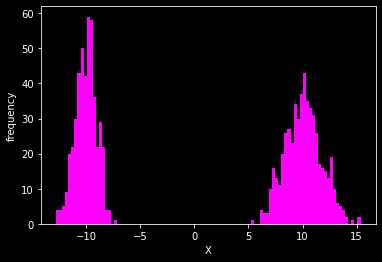

In [8]:
plt.style.use('dark_background')
plt.hist(O[:, 0], 100, color='blue')
plt.xlabel('X')
plt.ylabel('frequency')
plt.grid(False)
plt.savefig('ContGauss_x1_sim.png', transparent=True, dpi=600)
plt.show()

plt.hist(O[:, 1], 100, color='lime')
plt.xlabel('X')
plt.ylabel('frequency')
plt.grid(False)
plt.savefig('ContGauss_x2_sim.png', transparent=True, dpi=600)
plt.show()

plt.hist(O[:, 2], 100, color='magenta')
plt.xlabel('X')
plt.ylabel('frequency')
plt.grid(False)
plt.savefig('ContGauss_x3_sim.png', transparent=True, dpi=600)
plt.show()



Applying K Means Clustering to have an initial estimate, simulating it and plotting the histogram

In [12]:
kmeans=KMeans(n_clusters=2)
df = pd.DataFrame(O[300:325], columns = ['1','2','3'])
kmeans=kmeans.fit(df)
labels=kmeans.predict(df)

Oa=[]
Ob=[]

for i in range(len(labels[:50])):
    
    l=labels[i]
    
    if l==0:
        Oa.append(O[i])
        
    if l==1:
        Ob.append(O[i])
        
Oa=np.transpose(np.array(Oa))
Ob=np.transpose(np.array(Ob))

σpa=np.cov(Oa)
σpb=np.cov(Ob)

μsa=np.array([np.mean(Oa[0, :]), np.mean(Oa[1, :]), np.mean(Oa[2, :])])
μsb=np.array([np.mean(Ob[0, :]), np.mean(Ob[1, :]), np.mean(Ob[2, :])])

In [13]:
A2=State(3)
B2=State(3)


A2.μ=μsa
A2.σ=σpa

B2.μ=μsb
B2.σ=σpb

C2=HMM()
C2.States=[A2, B2]
C2.A=np.array([[0.2, 0.8], [0.8, 0.2]])
C2.p=np.array([0.2, 0.8])

C2.printx()

[0.2 0.8]
[[0.2 0.8]
 [0.8 0.2]]

State 1:
[-5.73046944 -5.05485601  5.50054183]
[[ 73.6186335   71.95491669 -69.05044782]
 [ 71.95491669  72.57856834 -67.45931867]
 [-69.05044782 -67.45931867  73.48077244]]
State 2:
[ 3.10743824  2.64199163 -3.24115394]
[[ 103.13100611   98.13228513 -103.24419618]
 [  98.13228513   98.00967647  -99.84129542]
 [-103.24419618  -99.84129542  105.4201623 ]]





In [14]:
O2=[]
S2=[]
for i in range(1000):
    o2, s2=C2.sim()
    O2.append(o2)
    S2.append(s2)
    
O2=np.array(O2)


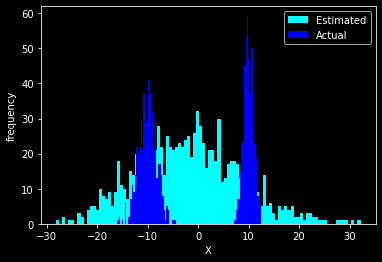

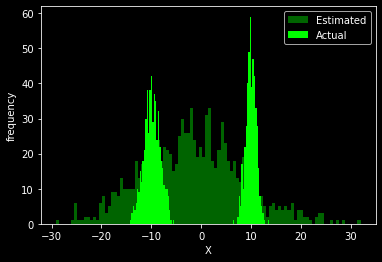

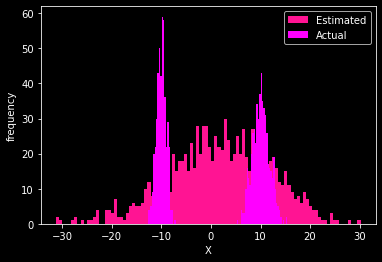

In [15]:
plt.style.use('dark_background')

plt.hist(O2[:, 0], 100, color='aqua')
plt.hist(O[:1000, 0], 100, color='blue')
plt.xlabel('X')
plt.ylabel('frequency')
plt.grid(False)
plt.legend(['Estimated', 'Actual'], loc=1)
plt.savefig('ContGauss_x1_est1.png', transparent=True, dpi=600)
plt.show()

plt.hist(O2[:, 1], 100, color='darkgreen')
plt.hist(O[:1000, 1], 100, color='lime')
plt.xlabel('X')
plt.ylabel('frequency')
plt.grid(False)
plt.legend(['Estimated', 'Actual'], loc=1)
plt.savefig('ContGauss_x2_est1.png', transparent=True, dpi=600)
plt.show()

plt.hist(O2[:, 2], 100, color='deeppink')
plt.hist(O[:1000, 2], 100, color='magenta')
plt.xlabel('X')
plt.ylabel('frequency')
plt.grid(False)
plt.legend(['Estimated', 'Actual'], loc=1)
plt.savefig('ContGauss_x3_est1.png', transparent=True, dpi=600)
plt.show()

Now we train this with EM algorithm, and simulate and plot histograms

In [16]:
for i in range(10):
    C2.EM(O[:500])

In [17]:
O2=[]
S2=[]
for i in range(1000):
    o2, s2=C2.sim()
    O2.append(o2)
    S2.append(s2)
    
O2=np.array(O2)


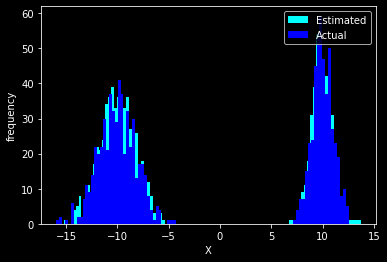

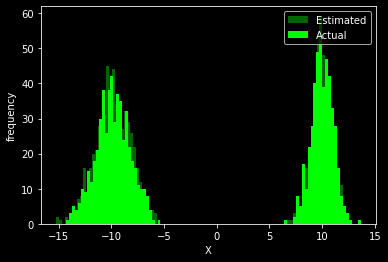

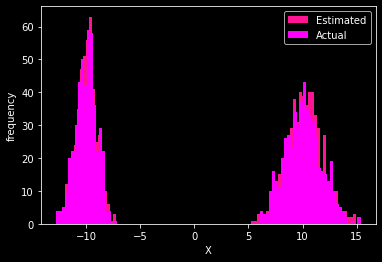

In [18]:
plt.style.use('dark_background')

plt.hist(O2[:, 0], 100, color='aqua')
plt.hist(O[:1000, 0], 100, color='blue')
plt.xlabel('X')
plt.ylabel('frequency')
plt.grid(False)
plt.legend(['Estimated', 'Actual'], loc=1)
plt.savefig('ContGauss_x1_est2.png', transparent=True, dpi=600)
plt.show()

plt.hist(O2[:, 1], 100, color='darkgreen')
plt.hist(O[:1000, 1], 100, color='lime')
plt.xlabel('X')
plt.ylabel('frequency')
plt.grid(False)
plt.legend(['Estimated', 'Actual'], loc=1)
plt.savefig('ContGauss_x2_est2.png', transparent=True, dpi=600)
plt.show()

plt.hist(O2[:, 2], 100, color='deeppink')
plt.hist(O[:1000, 2], 100, color='magenta')
plt.xlabel('X')
plt.ylabel('frequency')
plt.grid(False)
plt.legend(['Estimated', 'Actual'], loc=1)
plt.savefig('ContGauss_x3_est2.png', transparent=True, dpi=600)
plt.show()
